In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

X_train = np.load('../data/X_train.npy')
Y_train = np.load('../data/y_train.npy')


X_val = np.load('../data/processed_data/m4021_session1/X.npy')
Y_val = np.load('../data/processed_data/m4021_session1/y_all.npy')

In [17]:
batch_size = 500
time_window = 500
n_dim = 1
predict_early = 0

input_shape = (time_window, n_dim)

In [18]:
train_generator = generator(X_train, Y_train, batch_size, time_window)
validate_generator = generator(X_val, Y_val, batch_size, time_window)

In [19]:
model = generate_model_CNN(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 20)           160       
_________________________________________________________________
average_pooling1d_1 (Average (None, 250, 20)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 20)           80        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 20)           2820      
_________________________________________________________________
average_pooling1d_2 (Average (None, 125, 20)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 20)           80        
__________

In [20]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=10,
                              epochs=150, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=10,
                              )

save_model(model, name=predict_early)

Epoch 1/150
10/10 [==============================] - 15s 1s/step - loss: 0.7762 - acc: 0.6276 - val_loss: 0.6624 - val_acc: 0.7132
Epoch 2/150
10/10 [==============================] - 7s 705ms/step - loss: 0.5090 - acc: 0.7602 - val_loss: 2.7750 - val_acc: 0.6612
Epoch 3/150
10/10 [==============================] - 6s 646ms/step - loss: 0.4582 - acc: 0.7970 - val_loss: 4.8062 - val_acc: 0.6494
Epoch 4/150
10/10 [==============================] - 6s 627ms/step - loss: 0.4286 - acc: 0.8096 - val_loss: 4.0504 - val_acc: 0.6624
Epoch 5/150
10/10 [==============================] - 6s 629ms/step - loss: 0.4380 - acc: 0.8056 - val_loss: 2.0153 - val_acc: 0.6466
Epoch 6/150
10/10 [==============================] - 6s 638ms/step - loss: 0.4194 - acc: 0.8170 - val_loss: 1.6538 - val_acc: 0.6558
Epoch 7/150
10/10 [==============================] - 6s 610ms/step - loss: 0.3921 - acc: 0.8270 - val_loss: 1.9094 - val_acc: 0.6604
Epoch 8/150
10/10 [==============================] - 6s 598ms/step - lo

10/10 [==============================] - 5s 531ms/step - loss: 0.0459 - acc: 0.9810 - val_loss: 0.1946 - val_acc: 0.9334
Epoch 63/150
10/10 [==============================] - 5s 531ms/step - loss: 0.0406 - acc: 0.9854 - val_loss: 0.0885 - val_acc: 0.9626
Epoch 64/150
10/10 [==============================] - 5s 537ms/step - loss: 0.0509 - acc: 0.9796 - val_loss: 0.3903 - val_acc: 0.8688
Epoch 65/150
10/10 [==============================] - 6s 551ms/step - loss: 0.0502 - acc: 0.9812 - val_loss: 0.5946 - val_acc: 0.8268
Epoch 66/150
10/10 [==============================] - 5s 540ms/step - loss: 0.0565 - acc: 0.9810 - val_loss: 0.7640 - val_acc: 0.7794
Epoch 67/150
10/10 [==============================] - 5s 530ms/step - loss: 0.0591 - acc: 0.9788 - val_loss: 0.1971 - val_acc: 0.9216
Epoch 68/150
10/10 [==============================] - 5s 521ms/step - loss: 0.0545 - acc: 0.9794 - val_loss: 0.2379 - val_acc: 0.9046
Epoch 69/150
10/10 [==============================] - 6s 590ms/step - loss:

10/10 [==============================] - 5s 525ms/step - loss: 0.0332 - acc: 0.9882 - val_loss: 0.1808 - val_acc: 0.9316
Epoch 124/150
10/10 [==============================] - 5s 523ms/step - loss: 0.0307 - acc: 0.9888 - val_loss: 0.6703 - val_acc: 0.8262
Epoch 125/150
10/10 [==============================] - 5s 521ms/step - loss: 0.0247 - acc: 0.9904 - val_loss: 3.8059 - val_acc: 0.6560
Epoch 126/150
10/10 [==============================] - 5s 535ms/step - loss: 0.0243 - acc: 0.9916 - val_loss: 3.0236 - val_acc: 0.6846
Epoch 127/150
10/10 [==============================] - 5s 516ms/step - loss: 0.0371 - acc: 0.9866 - val_loss: 3.4451 - val_acc: 0.6728
Epoch 128/150
10/10 [==============================] - 5s 540ms/step - loss: 0.0303 - acc: 0.9900 - val_loss: 2.3285 - val_acc: 0.6936
Epoch 129/150
10/10 [==============================] - 5s 527ms/step - loss: 0.0211 - acc: 0.9914 - val_loss: 3.0406 - val_acc: 0.6646
Epoch 130/150
10/10 [==============================] - 5s 530ms/step 

<IPython.core.display.Javascript object>


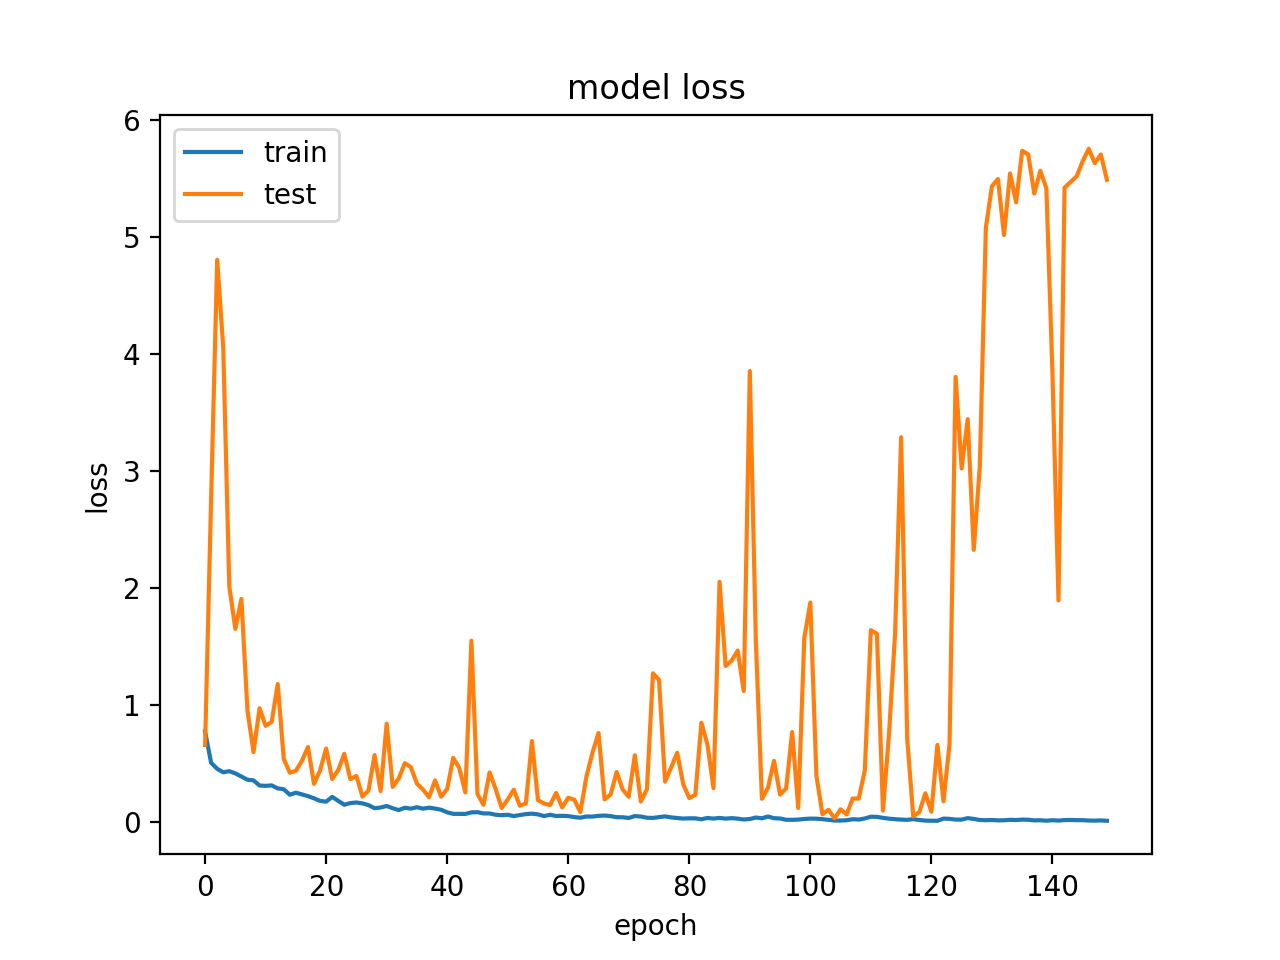

<IPython.core.display.Javascript object>


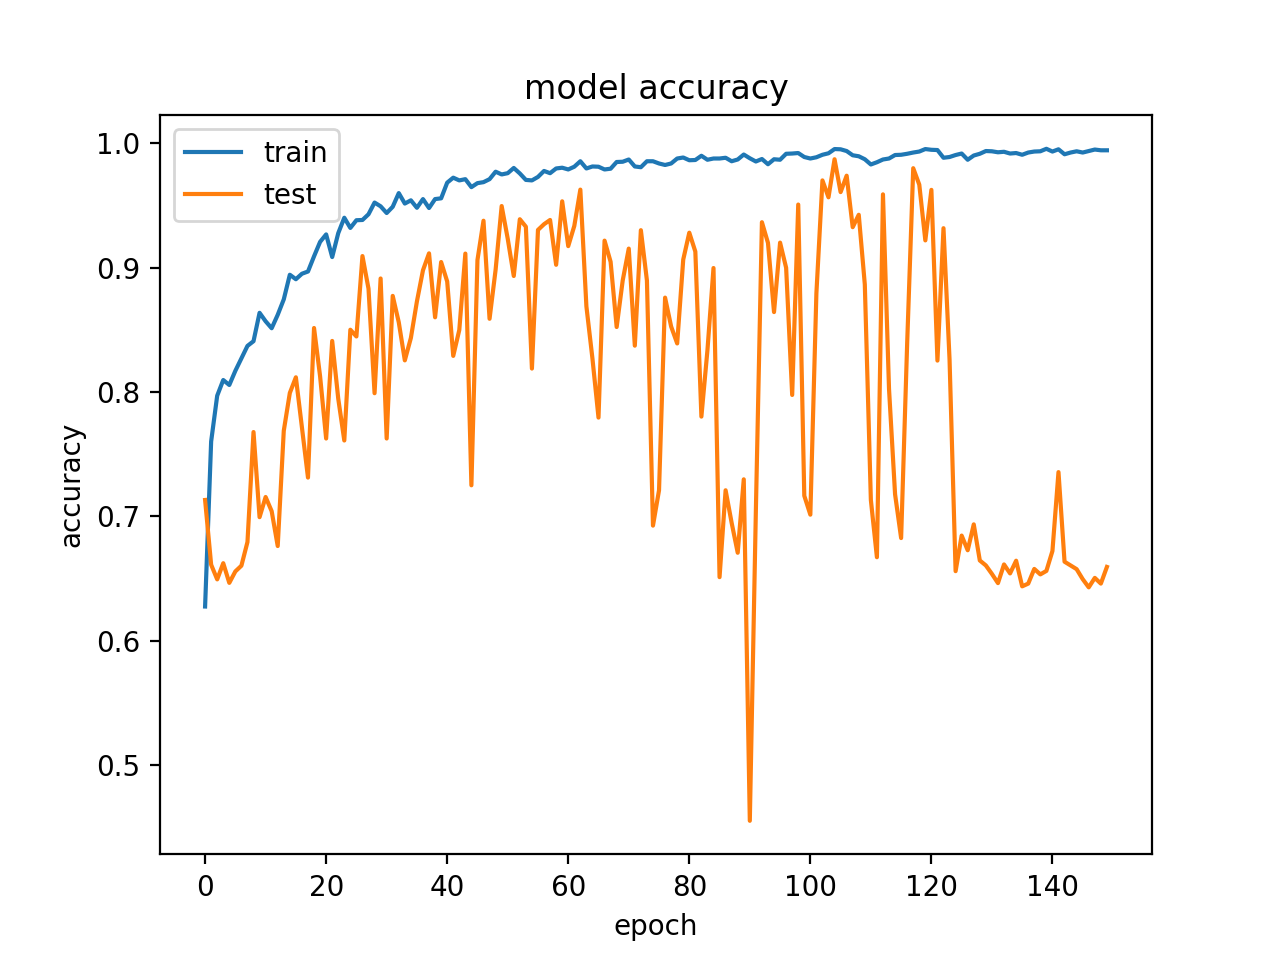

In [21]:
plot_performance(history)